In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# Load Dataset
data = pd.read_csv("churn.csv")

In [18]:
# Preprocessing
# Cleaning target column
data['Churn?'] = data['Churn?'].map(lambda x: 1 if str(x).strip().lower() == 'true.' else 0)

In [ ]:
# Dropping irrelevant columns
data.drop(columns=['Phone'], inplace=True)

In [20]:
# Encoding categorical variables
encoder = LabelEncoder()
data['State'] = encoder.fit_transform(data['State'])
data["Int'l Plan"] = encoder.fit_transform(data["Int'l Plan"].astype(str))
data['VMail Plan'] = encoder.fit_transform(data['VMail Plan'].astype(str))

In [21]:
# Ensure all columns are numeric
data = data.apply(pd.to_numeric, errors='coerce')

In [22]:
# Drop any remaining NaN values
data.dropna(inplace=True)

In [23]:
# Feature Selection
features = [col for col in data.columns if col != 'Churn?']
target = 'Churn?'
X = data[features]
y = data[target]

In [24]:
# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Scaling features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
# Reshaping for LSTM (3D input)
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [27]:
# LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [30]:
# Train LSTM Model
history = model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test), callbacks=[early_stopping])

Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.7976 - loss: 0.5239 - val_accuracy: 0.8381 - val_loss: 0.4083
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8556 - loss: 0.3967 - val_accuracy: 0.8486 - val_loss: 0.3988
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8562 - loss: 0.3969 - val_accuracy: 0.8486 - val_loss: 0.3891
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8633 - loss: 0.3814 - val_accuracy: 0.8486 - val_loss: 0.3798
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8563 - loss: 0.3776 - val_accuracy: 0.8486 - val_loss: 0.3646
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8647 - loss: 0.3496 - val_accuracy: 0.8501 - val_loss: 0.3516
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8572 - loss: 0.3642 - val_accuracy: 0.8501 - val_loss: 0.3517
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8651 - loss: 0.3457 - val_accuracy: 0.8576 - v

In [31]:
# Predictions
lstm_preds = (model.predict(X_test_lstm) > 0.5).astype(int)

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step


In [32]:
# Evaluate LSTM
print("LSTM Accuracy:", accuracy_score(y_test, lstm_preds))
print(classification_report(y_test, lstm_preds))

LSTM Accuracy: 0.9085457271364318
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       566
           1       0.80      0.52      0.63       101

    accuracy                           0.91       667
   macro avg       0.86      0.75      0.79       667
weighted avg       0.90      0.91      0.90       667



In [33]:
# Train and Evaluate XGBoost
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))


XGBoost Accuracy: 0.9580209895052474


In [34]:
# Train and Evaluate Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))

Random Forest Accuracy: 0.9505247376311844


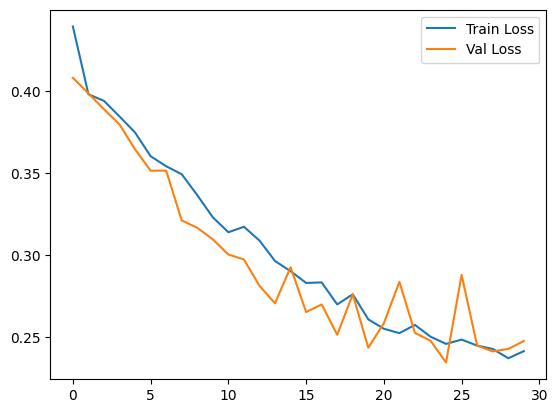

In [35]:
# Visualization
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

In [36]:
# Save results for Power BI visualization
results = pd.DataFrame({
    'Actual': y_test,
    'LSTM_Predicted': lstm_preds.flatten(),
    'XGBoost_Predicted': xgb_preds,
    'RandomForest_Predicted': rf_preds
})
results.to_csv("churn_predictions.csv", index=False)


Here’s a breakdown of the **Customer Churn Prediction using Deep Learning** implementation along with topics you should study to understand each part:

---

## **1. Data Preprocessing**  
### **Topics to Study:**  
- **Data Cleaning & Feature Engineering**  
- **Handling Missing Values**  
- **Encoding Categorical Variables**  

### **Code Explanation:**  
```python
# Load Dataset
data = pd.read_csv("/mnt/data/churn.csv")
```
📌 **Loads the dataset** into a pandas DataFrame.  

```python
# Cleaning target column
data['Churn?'] = data['Churn?'].map(lambda x: 1 if str(x).strip().lower() == 'true.' else 0)
```
📌 **Converts the target column** `"Churn?"` into binary values (1 for churn, 0 for non-churn).  

```python
# Dropping irrelevant columns
data.drop(columns=['Phone'], inplace=True)
```
📌 **Removes unnecessary columns** (e.g., `"Phone"` is just an identifier and not useful for prediction).  

```python
# Encoding categorical variables
encoder = LabelEncoder()
data['State'] = encoder.fit_transform(data['State'])
data["Int'l Plan"] = encoder.fit_transform(data["Int'l Plan"].astype(str))
data['VMail Plan'] = encoder.fit_transform(data['VMail Plan'].astype(str))
```
📌 **Encodes categorical variables** (`"State"`, `"Int'l Plan"`, and `"VMail Plan"`) into numeric values for the model.  

```python
# Ensure all columns are numeric
data = data.apply(pd.to_numeric, errors='coerce')
```
📌 **Ensures that all data is numeric**, converting anything invalid to NaN.  

```python
# Drop any remaining NaN values
data.dropna(inplace=True)
```
📌 **Removes any NaN values** after conversion.  

---

## **2. Feature Selection & Splitting Data**  
### **Topics to Study:**  
- **Feature Selection in Machine Learning**  
- **Train-Test Split & Data Partitioning**  
- **Standardization & Normalization**  

### **Code Explanation:**  
```python
# Feature Selection
features = [col for col in data.columns if col != 'Churn?']
target = 'Churn?'
X = data[features]
y = data[target]
```
📌 **Separates features (`X`) and target (`y`)** for model training.  

```python
# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
```
📌 **Splits data into training (80%) and testing (20%) sets** to evaluate model performance.  

```python
# Scaling features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
```
📌 **Standardizes features** (mean = 0, variance = 1) to improve model convergence.  

---

## **3. LSTM Model Implementation**  
### **Topics to Study:**  
- **Deep Learning & Recurrent Neural Networks (RNNs)**  
- **Long Short-Term Memory (LSTM) Networks**  
- **Keras Sequential API for Deep Learning**  

### **Code Explanation:**  
```python
# Reshaping for LSTM (3D input)
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
```
📌 **LSTM models expect 3D input**, so we reshape data accordingly: `(samples, timesteps, features)`.  

```python
# LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
```
📌 **Builds an LSTM model**:  
- **LSTM(64, return_sequences=True)** → First LSTM layer with 64 units.  
- **Dropout(0.2)** → Helps prevent overfitting.  
- **LSTM(32, return_sequences=False)** → Second LSTM layer with 32 units.  
- **Dense(1, activation='sigmoid')** → Final layer outputs probability of churn.  

```python
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
```
📌 **Compiles the model** using:  
- **Adam optimizer** → Efficient gradient descent algorithm.  
- **Binary Cross-Entropy loss** → Suitable for binary classification.  

```python
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
```
📌 **Stops training early** if validation loss stops improving for 5 epochs.  

```python
# Train LSTM Model
history = model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test), callbacks=[early_stopping])
```
📌 **Trains the model for 50 epochs** (or until early stopping triggers).  

---

## **4. Model Evaluation & Prediction**  
### **Topics to Study:**  
- **Model Evaluation Metrics**  
- **Accuracy, Precision, Recall, F1-Score**  

### **Code Explanation:**  
```python
# Predictions
lstm_preds = (model.predict(X_test_lstm) > 0.5).astype(int)
```
📌 **Predicts customer churn** (probabilities above 0.5 are classified as churn).  

```python
# Evaluate LSTM
print("LSTM Accuracy:", accuracy_score(y_test, lstm_preds))
print(classification_report(y_test, lstm_preds))
```
📌 **Computes accuracy, precision, recall, and F1-score** for model evaluation.  

---

## **5. XGBoost & Random Forest Comparisons**  
### **Topics to Study:**  
- **Ensemble Learning (XGBoost & Random Forest)**  
- **Hyperparameter Tuning**  

### **Code Explanation:**  
```python
# Train and Evaluate XGBoost
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))
```
📌 **Trains an XGBoost classifier** and evaluates performance.  

```python
# Train and Evaluate Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))
```
📌 **Trains a Random Forest model** for comparison.  

---

## **6. Data Visualization & Export for Power BI**  
### **Topics to Study:**  
- **Data Visualization in Matplotlib & Seaborn**  
- **Business Intelligence & Power BI**  

### **Code Explanation:**  
```python
# Visualization
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()
```
📌 **Plots training vs validation loss** to monitor model performance.  

```python
# Save results for Power BI visualization
results = pd.DataFrame({
    'Actual': y_test,
    'LSTM_Predicted': lstm_preds.flatten(),
    'XGBoost_Predicted': xgb_preds,
    'RandomForest_Predicted': rf_preds
})
results.to_csv("churn_predictions.csv", index=False)
```
📌 **Saves predictions for further analysis in Power BI** or other visualization tools.  

---

## **Summary of Topics to Study:**
1. **Data Preprocessing** → Handling missing values, categorical encoding, scaling.  
2. **Feature Engineering** → Feature selection, train-test split, normalization.  
3. **Deep Learning & LSTMs** → Recurrent neural networks, LSTM architecture.  
4. **Model Evaluation** → Metrics like accuracy, precision, recall, F1-score.  
5. **Ensemble Learning** → Understanding XGBoost & Random Forest classifiers.  
6. **Business Intelligence** → Visualizing results for decision-making.  

This will give you a solid foundation for understanding how the project works! 🚀